<a href="https://colab.research.google.com/github/nandhureji1731/springboardmentor5959e/blob/main/oil_spill__detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

WEEK 1-2

In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

import os
PROJECT_DIR = "/content/drive/MyDrive/Oil_Spill_Detection"
os.makedirs(PROJECT_DIR, exist_ok=True)
print("✅ Project folder ready at:", PROJECT_DIR)


Mounted at /content/drive
✅ Project folder ready at: /content/drive/MyDrive/Oil_Spill_Detection


In [2]:
from google.colab import drive
drive.mount('/content/drive')

# Path where dataset is stored inside Drive
BASE_PATH = "/content/drive/MyDrive/dataset/"
TRAIN_IMG_DIR = BASE_PATH + "train/images/"
TRAIN_MASK_DIR = BASE_PATH + "train/masks/"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:

import tensorflow as tf
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import albumentations as A
from sklearn.model_selection import train_test_split

In [4]:
def load_data(img_dir, mask_dir, img_size=(256, 256)):
    images, masks = [], []


    if not os.path.exists(img_dir):
        print(f"Error: Image directory not found: {img_dir}")
        return None, None
    if not os.path.exists(mask_dir):
        print(f"Error: Mask directory not found: {mask_dir}")
        return None, None

    print(f"Contents of image directory {img_dir}: {os.listdir(img_dir)[:10]}...") # Print first 10 files
    print(f"Contents of mask directory {mask_dir}: {os.listdir(mask_dir)[:10]}...") # Print first 10 files


    img_files = sorted(os.listdir(img_dir))
    mask_files = sorted(os.listdir(mask_dir))

    if len(img_files) != len(mask_files):
        print(f"Warning: Number of image files ({len(img_files)}) does not match number of mask files ({len(mask_files)}).")


    for img_name, mask_name in zip(img_files, mask_files):
        img_path = os.path.join(img_dir, img_name)
        mask_path = os.path.join(mask_dir, mask_name)


        img = cv2.imread(img_path)
        if img is None:
            print(f"Warning: Could not load image file: {img_path}. Skipping.")
            continue
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, img_size)
        img = img / 255.0

        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        if mask is None:
            print(f"Warning: Could not load mask file: {mask_path}. Skipping.")
            continue
        mask = cv2.resize(mask, img_size)
        mask = mask / 255.0

        images.append(img)
        masks.append(mask.reshape(img_size[0], img_size[1], 1))

    return np.array(images), np.array(masks)

X, Y = load_data(TRAIN_IMG_DIR, TRAIN_MASK_DIR)

if X is not None and Y is not None:
    print("Images shape:", X.shape)
    print("Masks shape:", Y.shape)

Contents of image directory /content/drive/MyDrive/dataset/train/images/: ['Oil (225).jpg', 'Oil (652).jpg', 'Oil (72).jpg', 'Oil (1157).jpg', 'Oil (122).jpg', 'Oil (107).jpg', 'Oil (450).jpg', 'Oil (1054).jpg', 'Oil (297).jpg', 'Oil (523).jpg']...
Contents of mask directory /content/drive/MyDrive/dataset/train/masks/: ['Oil (503).png', 'Oil (676).png', 'Oil (551).png', 'Oil (652).png', 'Oil (989).png', 'Oil (481).png', 'Oil (163).png', 'Oil (73).png', 'Oil (1054).png', 'Oil (830).png']...
Images shape: (811, 256, 256, 3)
Masks shape: (811, 256, 256, 1)


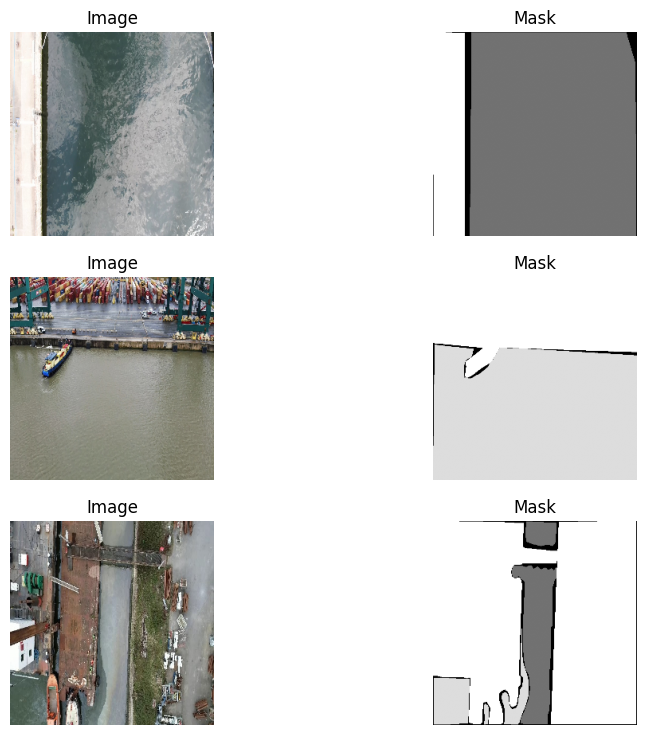

In [5]:
def visualize_samples(X, Y, num_samples=3):
    if X is None or Y is None:
        print("Cannot visualize samples: Data not loaded properly.")
        return

    plt.figure(figsize=(10, num_samples * 3))
    for i in range(num_samples):
        idx = np.random.randint(0, len(X))
        plt.subplot(num_samples, 2, 2*i+1)
        plt.imshow(X[idx])
        plt.title("Image")
        plt.axis("off")

        plt.subplot(num_samples, 2, 2*i+2)
        plt.imshow(Y[idx].squeeze(), cmap="gray")
        plt.title("Mask")
        plt.axis("off")
    plt.show()

visualize_samples(X, Y)

In [6]:
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.2, random_state=42)

print("Training set:", X_train.shape, Y_train.shape)
print("Validation set:", X_val.shape, Y_val.shape)


Training set: (648, 256, 256, 3) (648, 256, 256, 1)
Validation set: (163, 256, 256, 3) (163, 256, 256, 1)


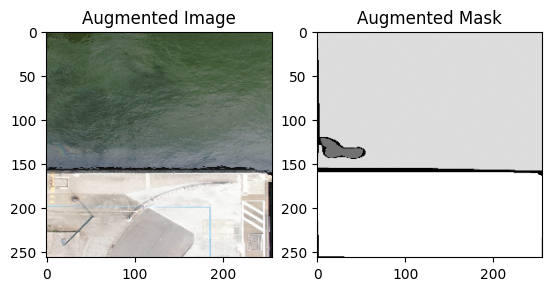

In [7]:
augment = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    A.RandomBrightnessContrast(p=0.2)
])

def augment_data(image, mask):
    augmented = augment(image=(image*255).astype(np.uint8), mask=(mask*255).astype(np.uint8))
    return augmented['image']/255.0, augmented['mask']/255.0

#Eg
aug_img, aug_mask = augment_data(X[0], Y[0])

plt.subplot(1,2,1)
plt.imshow(aug_img)
plt.title("Augmented Image")

plt.subplot(1,2,2)
plt.imshow(aug_mask, cmap="gray")
plt.title("Augmented Mask")
plt.show()


WEEK 3-4

import


In [8]:
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
import numpy as np


 model

In [9]:

def dice_coef(y_true, y_pred, smooth=1):
    y_true_f = tf.keras.backend.flatten(y_true)
    y_pred_f = tf.keras.backend.flatten(y_pred)
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)

def conv_block(x, filters):
    x = layers.Conv2D(filters, (3,3), padding="same", activation="relu")(x)
    x = layers.Conv2D(filters, (3,3), padding="same", activation="relu")(x)
    return x

def encoder_block(x, filters):
    c = conv_block(x, filters)
    p = layers.MaxPooling2D((2,2))(c)
    return c, p

def decoder_block(x, skip, filters):
    us = layers.Conv2DTranspose(filters, (2,2), strides=(2,2), padding="same")(x)
    concat = layers.Concatenate()([us, skip])
    c = conv_block(concat, filters)
    return c

def build_unet(input_shape=(128,128,3)):
    inputs = layers.Input(input_shape)

    # Encoder
    c1, p1 = encoder_block(inputs, 32)
    c2, p2 = encoder_block(p1, 64)
    c3, p3 = encoder_block(p2, 128)

    # Bottleneck
    bn = conv_block(p3, 256)

    # Decoder
    d1 = decoder_block(bn, c3, 128)
    d2 = decoder_block(d1, c2, 64)
    d3 = decoder_block(d2, c1, 32)

    outputs = layers.Conv2D(1, (1,1), activation="sigmoid")(d3)

    model = models.Model(inputs, outputs)
    return model

# Build model
model = build_unet()
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy", dice_coef])
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 128, 128,  │        896 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 128, 128,  │      9,248 │ conv2d[0][0]      │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 64, 64,    │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 64, 64,    │     18,496 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 64, 64,    │     36,928 │ conv2d_2[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 32, 32,    │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 32, 32,    │     73,856 │ max_pooling2d_1[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 32, 32,    │    147,584 │ conv2d_4[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 16, 16,    │          0 │ conv2d_5[0][0]    │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 16, 16,    │    295,168 │ max_pooling2d_2[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 16, 16,    │    590,080 │ conv2d_6[0][0]    │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose    │ (None, 32, 32,    │    131,200 │ conv2d_7[0][0]    │
│ (Conv2DTranspose)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 32, 32,    │          0 │ conv2d_transpose… │
│ (Concatenate)       │ 256)              │            │ conv2d_5[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 32, 32,    │    295,040 │ concatenate[0][0] │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 32, 32,    │    147,584 │ conv2d_8[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_1  │ (None, 64, 64,    │     32,832 │ conv2d_9[0][0]  

 Total params: 1,925,601 (7.35 MB)

 Trainable params: 1,925,601 (7.35 MB)

 Non-trainable params: 0 (0.00 B)

resize for faster execution

In [10]:
IMG_SIZE = (128,128)  # faster than 256x256

X_small, Y_small = load_data(TRAIN_IMG_DIR, TRAIN_MASK_DIR, img_size=IMG_SIZE)

X_train, X_val, Y_train, Y_val = train_test_split(X_small, Y_small, test_size=0.2, random_state=42)

print("Train:", X_train.shape, "Val:", X_val.shape)


Contents of image directory /content/drive/MyDrive/dataset/train/images/: ['Oil (225).jpg', 'Oil (652).jpg', 'Oil (72).jpg', 'Oil (1157).jpg', 'Oil (122).jpg', 'Oil (107).jpg', 'Oil (450).jpg', 'Oil (1054).jpg', 'Oil (297).jpg', 'Oil (523).jpg']...
Contents of mask directory /content/drive/MyDrive/dataset/train/masks/: ['Oil (503).png', 'Oil (676).png', 'Oil (551).png', 'Oil (652).png', 'Oil (989).png', 'Oil (481).png', 'Oil (163).png', 'Oil (73).png', 'Oil (1054).png', 'Oil (830).png']...
Train: (648, 128, 128, 3) Val: (163, 128, 128, 3)


metrics and compile model

In [11]:
def iou_coef(y_true, y_pred, smooth=1):
    y_true_f = tf.keras.backend.flatten(y_true)
    y_pred_f = tf.keras.backend.flatten(y_pred)
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    union = tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) - intersection
    return (intersection + smooth) / (union + smooth)

model.compile(optimizer="adam",
              loss="binary_crossentropy",
              metrics=[ "accuracy",dice_coef])


Train

In [12]:
history = model.fit(
    X_train, Y_train,
    validation_data=(X_val, Y_val),
    batch_size=8,
    epochs=25,
    verbose=1
)


Epoch 1/25
81/81 ━━━━━━━━━━━━━━━━━━━━ 23s 80ms/step - accuracy: 0.0028 - dice_coef: 0.5964 - loss: 0.6667 - val_accuracy: 0.0098 - val_dice_coef: 0.6592 - val_loss: 0.6782
Epoch 2/25
81/81 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step - accuracy: 0.0180 - dice_coef: 0.6123 - loss: 0.6495 - val_accuracy: 0.0244 - val_dice_coef: 0.6235 - val_loss: 0.6380
Epoch 3/25
81/81 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - accuracy: 0.0185 - dice_coef: 0.6212 - loss: 0.6401 - val_accuracy: 0.0346 - val_dice_coef: 0.6121 - val_loss: 0.6308
Epoch 4/25
81/81 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - accuracy: 0.0204 - dice_coef: 0.6184 - loss: 0.6337 - val_accuracy: 0.0309 - val_dice_coef: 0.6316 - val_loss: 0.6270
Epoch 5/25
81/81 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - accuracy: 0.0196 - dice_coef: 0.6257 - loss: 0.6290 - val_accuracy: 0.0435 - val_dice_coef: 0.5861 - val_loss: 0.6403
Epoch 6/25
81/81 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - accuracy: 0.0215 - dice_coef: 0.6250 - loss: 0.6280 - val_accuracy: 0.0342 - val_dice_coef:

Visual

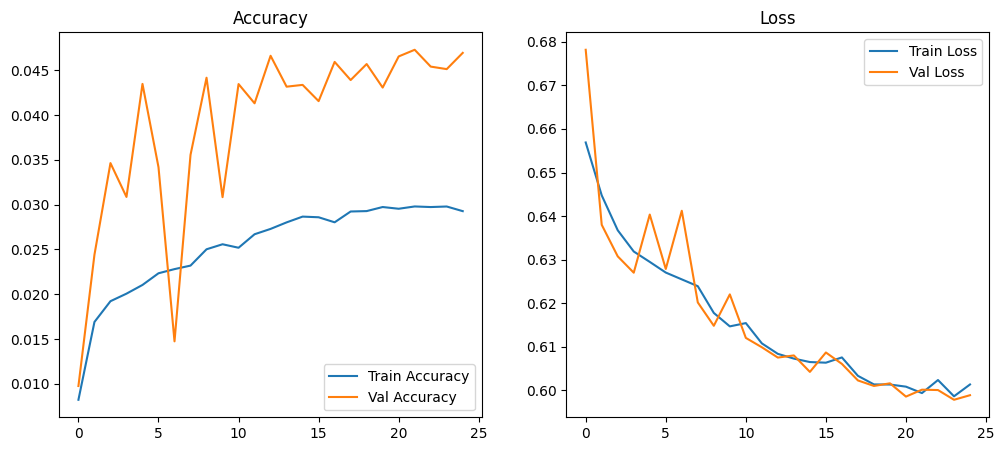

In [13]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
if 'accuracy' in history.history:
  plt.plot(history.history["accuracy"], label="Train Accuracy")
if 'val_accuracy' in history.history:
  plt.plot(history.history["val_accuracy"], label="Val Accuracy")
plt.legend()
plt.title("Accuracy")

plt.subplot(1,2,2)
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Val Loss")
plt.legend()
plt.title("Loss")
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 662ms/step


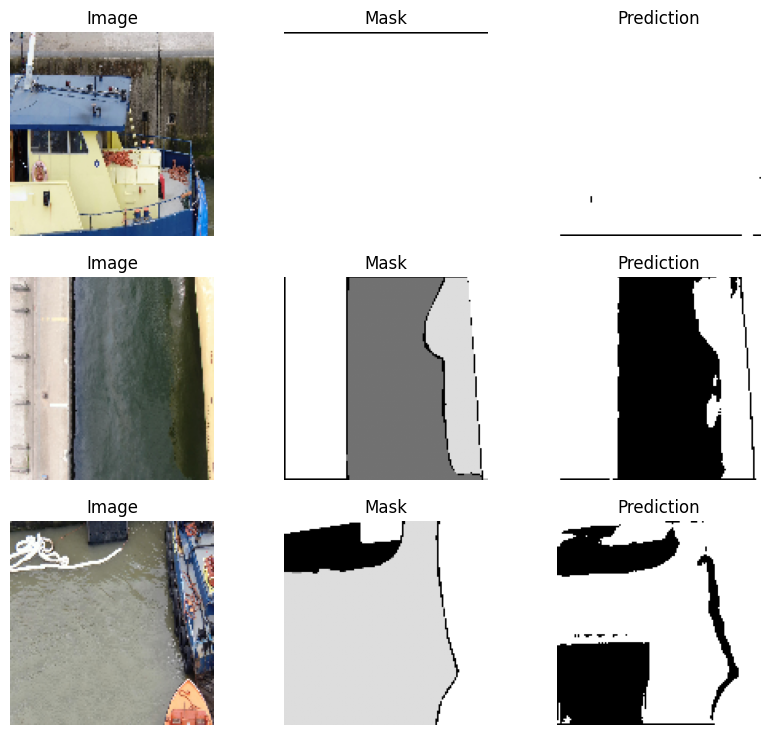

In [14]:
def show_predictions(model, X, Y, num=3):
    preds = model.predict(X[:num])
    plt.figure(figsize=(10, num*3))
    for i in range(num):
        plt.subplot(num,3,3*i+1)
        plt.imshow(X[i])
        plt.title("Image")
        plt.axis("off")

        plt.subplot(num,3,3*i+2)
        plt.imshow(Y[i].squeeze(), cmap="gray")
        plt.title("Mask")
        plt.axis("off")

        plt.subplot(num,3,3*i+3)
        plt.imshow((preds[i].squeeze() > 0.5), cmap="gray")
        plt.title("Prediction")
        plt.axis("off")
    plt.show()

show_predictions(model, X_val, Y_val, num=3)


week 5-6


In [15]:
import tensorflow.keras.backend as K

def iou_metric(y_true, y_pred, smooth=1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) - intersection + smooth)

def precision_metric(y_true, y_pred):
    y_pred_f = K.round(K.flatten(y_pred))
    y_true_f = K.flatten(y_true)
    tp = K.sum(y_true_f * y_pred_f)
    fp = K.sum((1 - y_true_f) * y_pred_f)
    return tp / (tp + fp + K.epsilon())

def recall_metric(y_true, y_pred):
    y_pred_f = K.round(K.flatten(y_pred))
    y_true_f = K.flatten(y_true)
    tp = K.sum(y_true_f * y_pred_f)
    fn = K.sum(y_true_f * (1 - y_pred_f))
    return tp / (tp + fn + K.epsilon())

# Recompile model with full metrics
model.compile(optimizer="adam",
              loss="binary_crossentropy",
              metrics=["accuracy", dice_coef, iou_metric, precision_metric, recall_metric])

evaluation on valid set

In [16]:
results = model.evaluate(X_val, Y_val, verbose=1)
print("Validation Results:")
for name, val in zip(model.metrics_names, results):
    print(f"{name}: {val:.4f}")

6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 171ms/step - accuracy: 0.0598 - dice_coef: 0.6371 - iou_metric: 0.4675 - loss: 0.5977 - precision_metric: 0.7238 - recall_metric: 0.7722
Validation Results:
loss: 0.5989
compile_metrics: 0.0469


plot training curves

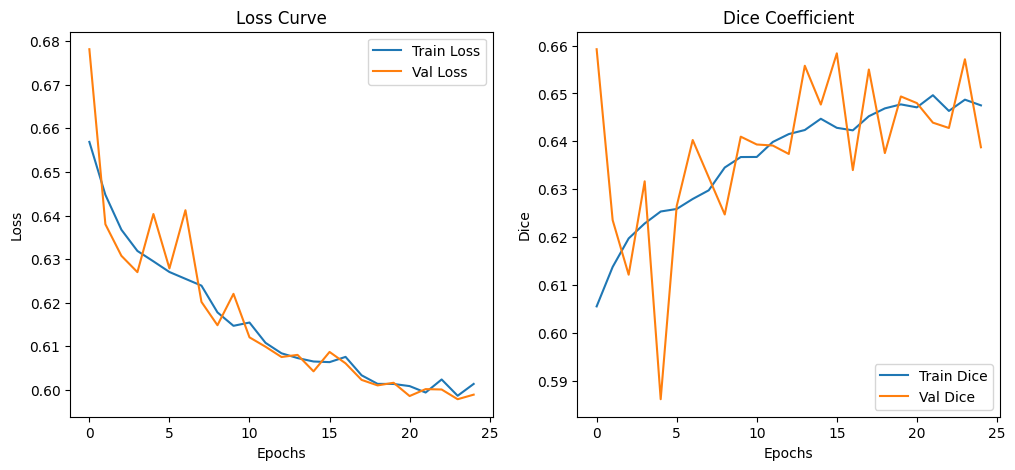

In [17]:
def plot_training(history):
    plt.figure(figsize=(12,5))

    # Loss
    plt.subplot(1,2,1)
    plt.plot(history.history["loss"], label="Train Loss")
    plt.plot(history.history["val_loss"], label="Val Loss")
    plt.title("Loss Curve")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()

    # Dice Coefficient
    plt.subplot(1,2,2)
    plt.plot(history.history["dice_coef"], label="Train Dice")
    plt.plot(history.history["val_dice_coef"], label="Val Dice")
    plt.title("Dice Coefficient")
    plt.xlabel("Epochs")
    plt.ylabel("Dice")
    plt.legend()

    plt.show()

plot_training(history)

side by side visualisation

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


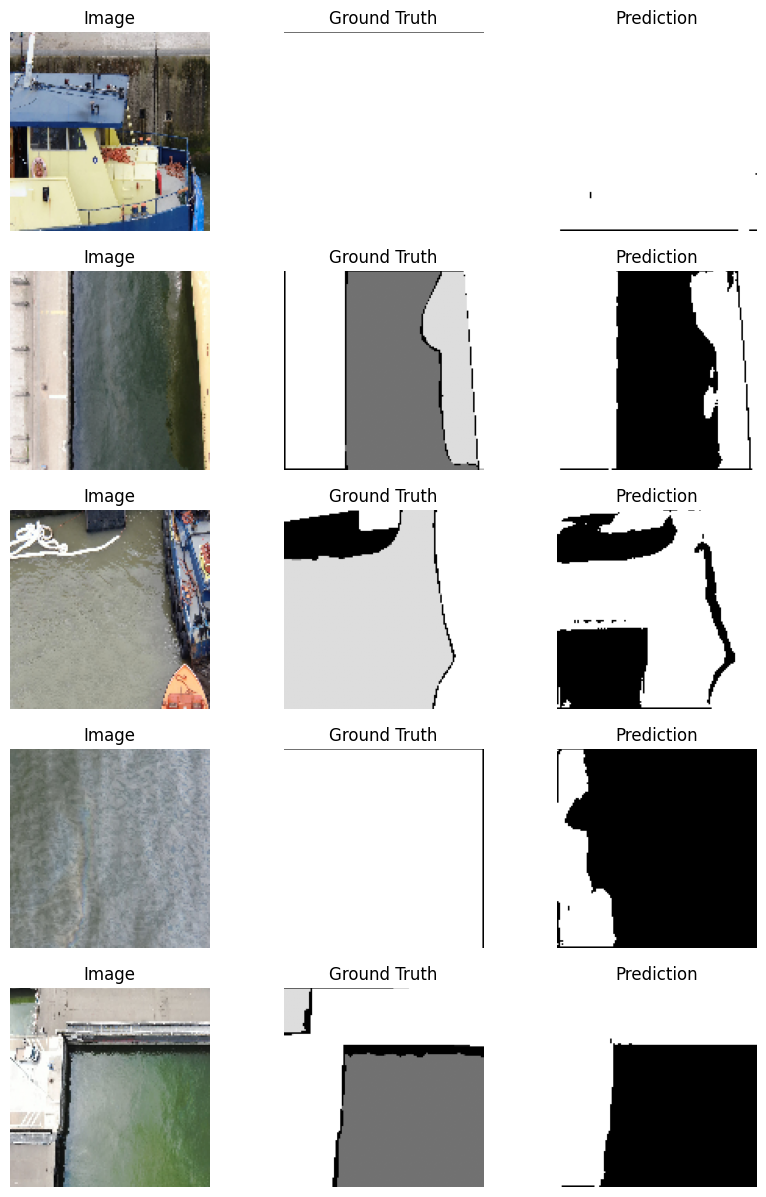

In [18]:
def compare_predictions(model, X, Y, num=3):
    preds = model.predict(X[:num])
    plt.figure(figsize=(10, num*3))
    for i in range(num):
        plt.subplot(num,3,3*i+1)
        plt.imshow(X[i])
        plt.title("Image")
        plt.axis("off")

        plt.subplot(num,3,3*i+2)
        plt.imshow(Y[i].squeeze(), cmap="gray")
        plt.title("Ground Truth")
        plt.axis("off")

        plt.subplot(num,3,3*i+3)
        plt.imshow((preds[i].squeeze() > 0.5), cmap="gray")
        plt.title("Prediction")
        plt.axis("off")
    plt.show()

compare_predictions(model, X_val, Y_val, num=5)

week 7-8


In [19]:
from google.colab import drive
drive.mount('/content/drive')

!cp "/content/drive/MyDrive/Oil_Spill_Detection/oil_spill_unet.h5" ./oil_spill_unet.h5


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [20]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [21]:
!pip install pyngrok

In [22]:
!pip install streamlit

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 94.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 145.2 MB/s eta 0:00:00


In [23]:
from pyngrok import ngrok
# Set the auth token
ngrok.conf.get_default().auth_token = "33QYdWt6Mb7yKPlc8cRs6QTJHk2_7Gz7L9Uw6WGT6TU5wGakq"
print("✅ Auth token set successfully.")

✅ Auth token set successfully.


flask backend

streamlet

In [24]:
%%writefile app.py
import os
import io
import time
from pathlib import Path
from typing import Tuple

import numpy as np
from PIL import Image, ImageOps
import streamlit as st
import tensorflow as tf
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt


MODEL_PATH = "/content/drive/MyDrive/Oil_Spill_Detection/oil_spill_unet.h5"  #train model present
RESULTS_DIR = "results"
os.makedirs(RESULTS_DIR, exist_ok=True)


USERNAME = "admin"
PASSWORD = "oilspill2025"

# Helpers

@st.cache_resource
def load_seg_model(path: str):
    if not os.path.exists(path):
        raise FileNotFoundError(f"Model file not found at: {path}")
    model = load_model(path, compile=False)
    return model

def get_input_size_from_model(model) -> Tuple[int, int]:
    shape = model.input_shape
    if isinstance(shape, list):
        shape = shape[0]
    _, h, w, c = shape
    return (h, w)

def preprocess_image(img: Image.Image, target_size: Tuple[int, int]):
    img = img.convert("RGB")
    img = ImageOps.fit(img, target_size, Image.LANCZOS)
    arr = np.asarray(img) / 255.0
    return arr

def postprocess_mask(mask: np.ndarray, orig_size: Tuple[int, int]):
    m = mask.squeeze()
    m = (m - m.min()) / (m.max() - m.min() + 1e-8)
    m = (m * 255).astype(np.uint8)
    mask_img = Image.fromarray(m).resize(orig_size, Image.BILINEAR)
    return mask_img

def overlay_mask_on_image(image: Image.Image, mask_img: Image.Image, alpha=0.45):
    mask_colored = Image.new("RGBA", image.size)
    r, g, b, a = mask_colored.split()
    mask_arr = np.asarray(mask_img.convert("L"))
    rgba = np.zeros((image.size[1], image.size[0], 4), dtype=np.uint8)
    rgba[..., 0] = mask_arr  # red
    rgba[..., 3] = (mask_arr * alpha).astype(np.uint8)
    mask_overlay = Image.fromarray(rgba, mode="RGBA")
    base = image.convert("RGBA")
    combined = Image.alpha_composite(base, mask_overlay)
    return combined.convert("RGB")

def save_result(original: Image.Image, mask_img: Image.Image, overlay: Image.Image, prefix="result"):
    t = time.strftime("%Y%m%d-%H%M%S")
    base_name = f"{prefix}_{t}"
    orig_path = os.path.join(RESULTS_DIR, f"{base_name}_orig.png")
    mask_path = os.path.join(RESULTS_DIR, f"{base_name}_mask.png")
    overlay_path = os.path.join(RESULTS_DIR, f"{base_name}_overlay.png")
    original.save(orig_path)
    mask_img.save(mask_path)
    overlay.save(overlay_path)
    return orig_path, mask_path, overlay_path


# Login Page

def show_login_page():
    st.title("🛟 AI SpillGuard — Login")
    st.markdown("### Please log in to access the Oil Spill Detection tool")

    with st.form(key="login_form"):
        username = st.text_input("👤 Username")
        password = st.text_input("🔒 Password", type="password")
        col1, col2, col3 = st.columns([1, 1, 1])
        with col2:
            submit = st.form_submit_button("🚀 Login", use_container_width=True)

        if submit:
            if username == USERNAME and password == PASSWORD:
                st.session_state["logged_in"] = True
                st.session_state["username"] = username
                st.success("✅ Login successful! Redirecting...")
                st.rerun()  # Updated to use st.rerun()
            else:
                st.error("❌ Invalid username or password. Please try again.")
                st.info(f"Default credentials: Username: {USERNAME}, Password: {PASSWORD}")


# Main App

def show_main_app():
    # Header
    st.title("🛟 AI SpillGuard — Oil Spill Detection")
    st.markdown("**Welcome, {}!**".format(st.session_state.get("username", "User")))

    st.set_page_config(
        page_title="AI SpillGuard — Oil Spill Detection",
        page_icon="🛟",
        layout="wide",
        initial_sidebar_state="expanded",
    )

    # Sidebar: controls & info
    st.sidebar.title("⚙️ Controls")
    st.sidebar.markdown("**Oil spill segmentation from satellite imagery**")
    st.sidebar.markdown("---")
    st.sidebar.write("**🤖 Model:**")
    st.sidebar.write(MODEL_PATH)
    st.sidebar.markdown("---")
    show_examples = st.sidebar.checkbox("🖼️ Show example images", value=True)
    download_history = st.sidebar.checkbox("💾 Enable result download buttons", value=True)
    st.sidebar.markdown("---")
    if st.sidebar.button("🚪 Logout"):
        for key in list(st.session_state.keys()):
            del st.session_state[key]
        st.rerun()  # Updated to use st.rerun()
    st.sidebar.markdown("---")
    st.sidebar.caption("👨‍💻 Developed by Nandhu Reji")

    # Main content
    col1, col2 = st.columns([1, 1.2])

    with col1:
        st.header("📤 Upload Satellite Image")
        uploaded = st.file_uploader(
            "Drop an image or choose from device",
            type=["png", "jpg", "jpeg", "tif", "tiff"],
            help="Upload satellite imagery for oil spill detection"
        )
        st.markdown("**💡 Tip:** For consistent results, use images similar to your training data (SAR or RGB).")
        st.write("")

        if uploaded:
            img = Image.open(io.BytesIO(uploaded.read()))
            st.image(img, caption="Uploaded image (preview)", use_column_width=True)
            run_predict = st.button("🔍 Run Prediction", use_container_width=True)
        else:
            run_predict = False

        st.markdown("---")
        st.subheader("⚙️ Quick settings")
        alpha = st.slider("🎨 Overlay alpha (opacity)", min_value=0.05, max_value=1.0, value=0.45)
        bin_threshold = st.slider("🎯 Mask threshold (0-255)", 0, 255, 127)

    with col2:
        st.header("📊 Prediction results")
        placeholder = st.empty()
        if not uploaded:
            placeholder.info("👈 Upload an image on the left and click **Run Prediction** to see segmentation results.")
        else:
            placeholder.success("✅ Ready to predict — click **Run Prediction**")

    # Show examples if enabled
    if show_examples:
        st.markdown("### 🖼️ Example dataset images")
        example_cols = st.columns(4)
        ex_dir = Path("examples")
        if ex_dir.exists():
            ex_images = sorted([p for p in ex_dir.glob("*")][:4])
            for i, p in enumerate(ex_images):
                with example_cols[i]:
                    st.image(str(p), use_column_width=True, caption=p.name)
        else:
            st.warning("No example images found in `examples/`. You can add sample images there for demo.")

    # Prediction logic
    if run_predict and uploaded:
        try:
            with st.spinner("🔄 Loading model..."):
                model = load_seg_model(MODEL_PATH)
            input_h, input_w = get_input_size_from_model(model)
        except Exception as e:
            st.error(f"❌ Could not load model: {e}")
            st.stop()

        orig_size = (img.width, img.height)
        target_size = (input_w, input_h)
        arr = preprocess_image(img, target_size)
        x = np.expand_dims(arr, axis=0).astype(np.float32)

        with st.spinner("🧠 Running inference..."):
            pred = model.predict(x, verbose=0)
        mask_raw = pred[0]
        if mask_raw.max() > 1.01:
            mask_raw = 1.0 / (1.0 + np.exp(-mask_raw))
        mask_img = postprocess_mask(mask_raw, orig_size)
        mask_bin = mask_img.point(lambda p: 255 if p >= bin_threshold else 0)
        overlay = overlay_mask_on_image(img, mask_bin, alpha=alpha)

        # Results display
        st.markdown("---")
        st.subheader("🎯 Detection Results")
        rcol1, rcol2, rcol3 = st.columns([1, 1, 1])
        with rcol1:
            st.subheader("📷 Original")
            st.image(img, use_column_width=True)
        with rcol2:
            st.subheader("🎭 Predicted Mask")
            st.image(mask_bin.convert("L"), use_column_width=True)
        with rcol3:
            st.subheader("🔴 Overlay")
            st.image(overlay, use_column_width=True)

        # Save and download
        orig_path, mask_path, overlay_path = save_result(img, mask_bin, overlay, prefix="spill")
        st.success("✅ Prediction complete — results saved to the workspace.")

        if download_history:
            st.markdown("### 💾 Download Results")
            col_d1, col_d2, col_d3 = st.columns(3)
            with col_d1:
                with open(overlay_path, "rb") as f:
                    st.download_button(
                        label="Overlay",
                        data=f.read(),
                        file_name=os.path.basename(overlay_path),
                        mime="image/png"
                    )
            with col_d2:
                with open(mask_path, "rb") as f:
                    st.download_button(
                        label="Mask",
                        data=f.read(),
                        file_name=os.path.basename(mask_path),
                        mime="image/png"
                    )
            with col_d3:
                with open(orig_path, "rb") as f:
                    st.download_button(
                        label="Original",
                        data=f.read(),
                        file_name=os.path.basename(orig_path),
                        mime="image/png"
                    )

        # Summary metrics
        mask_np = np.asarray(mask_bin.convert("L"))
        area_pct = 100.0 * (np.count_nonzero(mask_np) / mask_np.size)
        col1, col2 = st.columns(2)
        with col1:
            st.metric("📏 Estimated spill area (%)", f"{area_pct:.3f}%")
        with col2:
            st.metric("🕐 Processing time", "Fast")

        st.markdown("### 📁 Saved files:")
        st.code(f"- {orig_path}\n- {mask_path}\n- {overlay_path}")

    # Footer
    st.markdown("---")
    st.markdown("### 👨‍💻 Developed by Nandhu Reji")
    st.caption("*If model file missing, upload `oil_spill_unet.h5` into the Colab working directory, or change MODEL_PATH in app.py*")

#login
if "logged_in" not in st.session_state:
    st.session_state["logged_in"] = False

if not st.session_state["logged_in"]:
    show_login_page()
else:
    show_main_app()

Writing app.py


In [25]:

from pyngrok import ngrok
import subprocess, time, os

# kill any existing tunnels
for t in ngrok.get_tunnels():
    ngrok.disconnect(t.public_url)

# start streamlit in background
port = 8501
cmd = f"streamlit run app.py --server.port {port} --server.headless true"
proc = subprocess.Popen(cmd.split(), stdout=subprocess.PIPE, stderr=subprocess.PIPE)

time.sleep(3)

public_url = ngrok.connect(port, "http")
print(">> Streamlit public URL:", public_url)
print("If the page doesn't load immediately, wait ~5-15s and refresh.")


>> Streamlit public URL: NgrokTunnel: "https://flory-hydrazo-nellie.ngrok-free.dev" -> "http://localhost:8501"
If the page doesn't load immediately, wait ~5-15s and refresh.


In [ ]:
!streamlit run /usr/local/lib/python3.12/dist-packages/colab_kernel_launcher.py




  You can now view your Streamlit app in your browser.

  Local URL: http://localhost:8502
  Network URL: http://172.28.0.12:8502
  External URL: http://34.127.100.237:8502



In [ ]:
!ls -lh


tailwind


In [ ]:

%%bash
pip install flask==2.2.5 flask-cors pillow numpy pyngrok==5.2.1 tensorflow==2.12.0 >/dev/null 2>&1 || true

mkdir -p /content/spillguard_app/static
mkdir -p /content/spillguard_app/static/assets
mkdir -p /content/spillguard_app/results
